In [32]:
# https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

# Extract Relations

In [33]:
# conda install -c conda-forge spacy
# python3 -m spacy download en_core_web_sm

In [34]:
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [35]:
doc = nlp("Nagal won the first set.")
for tok in doc:
    print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [36]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [37]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            
            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
        
        #############################################################

    return [ent1.strip(), ent2.strip()]

In [38]:
def get_relation(sent):
    doc = nlp(sent)
    
    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},
               {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [40]:
candidate_sentences = pd.read_csv("transcript_converted.csv")

In [41]:
candidate_sentences

,Timestamp,Text
0,00:00:28.910,"Morning everyone, and welcome back. My name is Hassan Ajaburi. I'm an associate professor at the computer science department. I have phd in data mining, machine learning intelligence. It will be m..."
1,00:00:52.140,"Our course is computer systems organization. You can see here some information, general information about our meeting. So we will meet every Tuesday and Thursday in this classroom at 930. This is ..."
2,00:01:18.050,"Our course, we have good team who will work with you guys in this course. So if you need any help about the course itself, if you would like to reschedule something, if you would like to request a..."
3,00:01:58.370,"In these course guys, we will talk about different topics, actually. So you will see that we will move from one topic to another topic. So we will cover at the beginning, we'll introduce you to so..."
4,00:02:30.110,"And while we're talking about binary, we'll mention to some other numeral systems as well. So we'll mention a little bit about decimal so that you can compare between binary and decimal. We'll men..."
...,...,...
169,01:12:51.860,"The computer will not recognize that this is the number zero, the number one. It's just the character one."
170,01:13:00.800,"So you store characters. Each one of these characters will be stored as one byte. Okay, but you can be more specific. And when you use programming languages, and you can specify how to store the n..."
171,01:13:30.560,"I would like to store this number as short number. I would like to store this number as long number. And when it comes to float, you can specify, I would like to store this number as a float numbe..."
172,01:13:48.500,"And that's what we will cover next time. Okay, so let's just summarize everything we cover today. So today we explain about how to convert between nominal system between binary hexadecimal and dec..."


### Extract entity_pairs

In [44]:
entity_pairs = []
for i in tqdm(candidate_sentences["Text"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 174/174 [00:01<00:00, 120.78it/s]


In [46]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Text'])]

100%|██████████| 174/174 [00:01<00:00, 127.98it/s]


### Extract subject, Object

In [47]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


### Create and plot the directed-graph

In [48]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

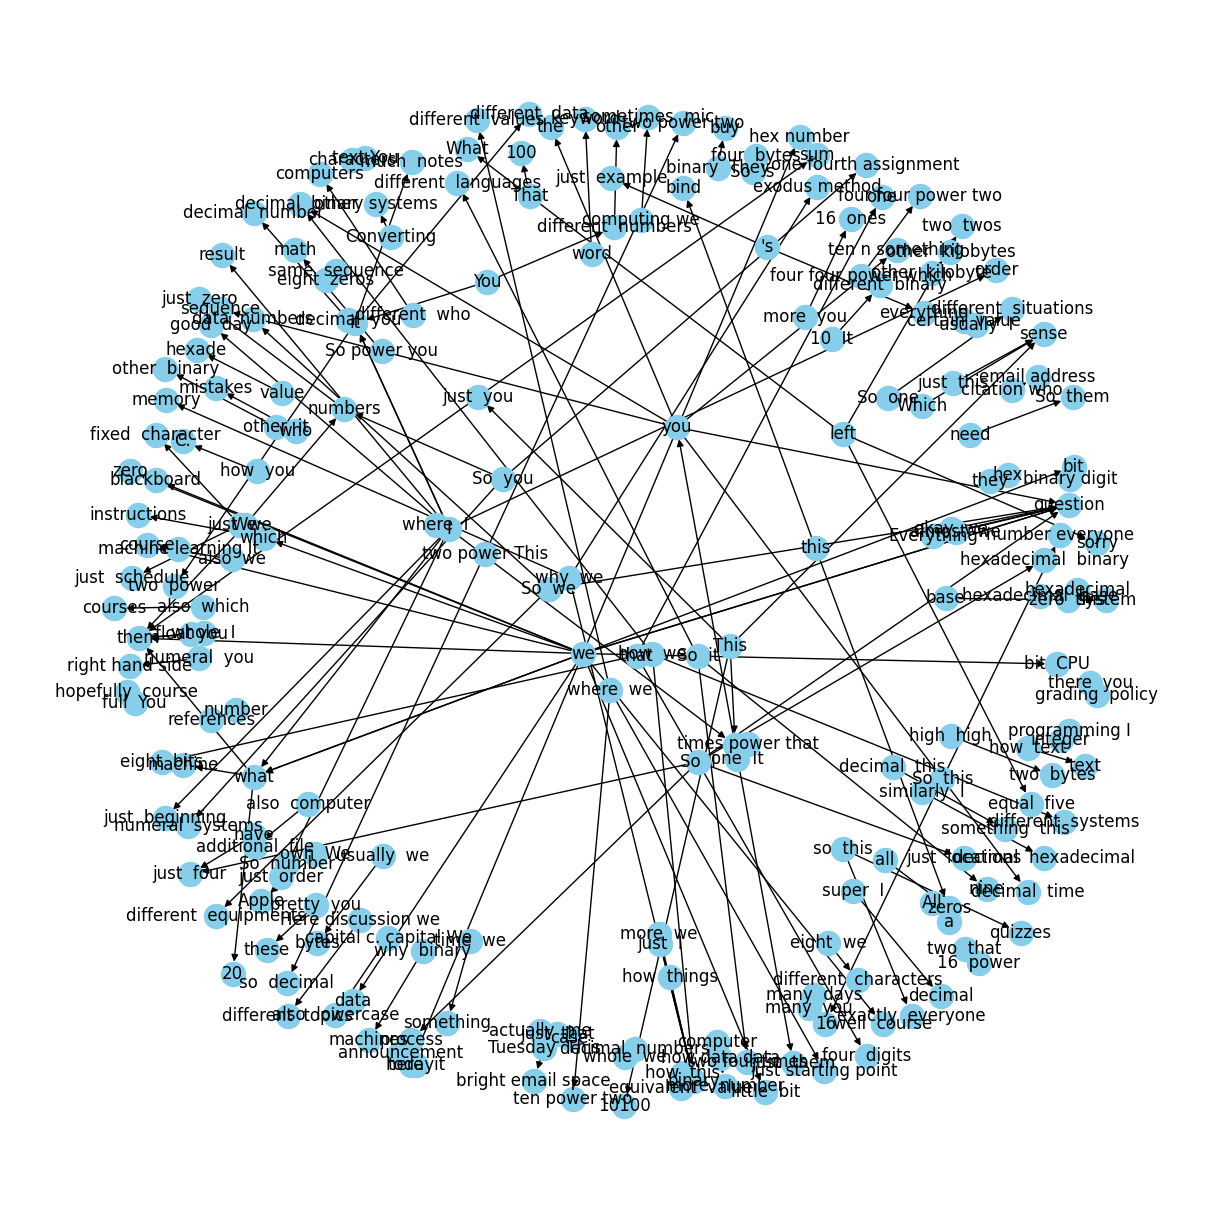

In [49]:
# Plot the Graph
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G) 
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


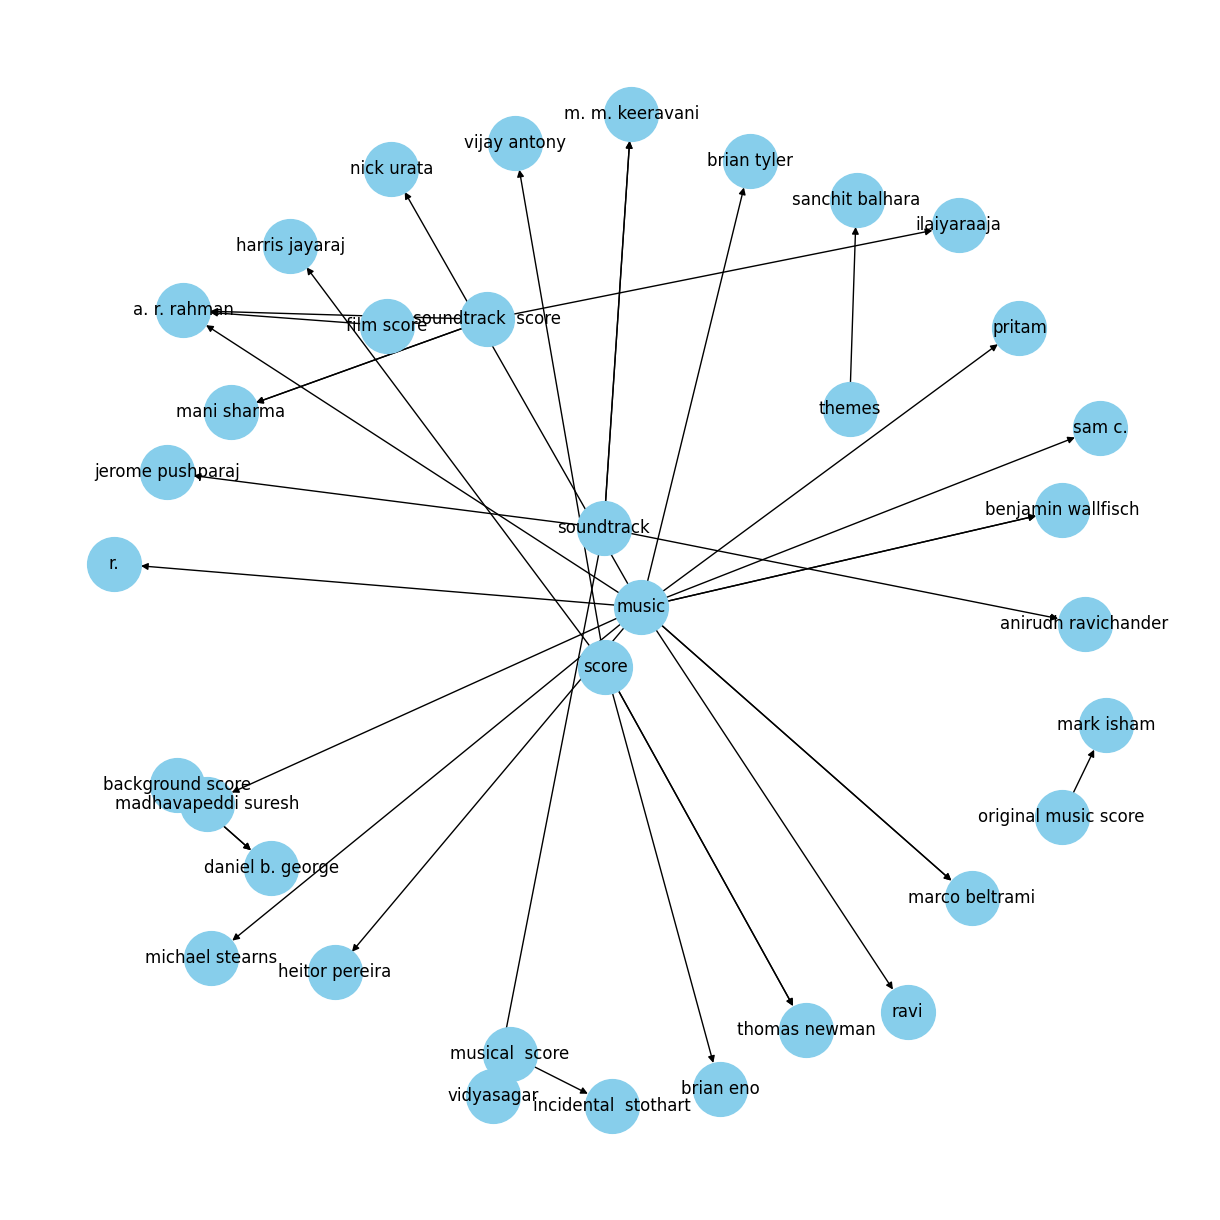

In [28]:
# take one relation at a time
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


In [29]:
import requests
txt = requests.get('https://en.wikipedia.org/wiki/Computer_science').text

In [30]:
from bs4 import BeautifulSoup
soup=BeautifulSoup(txt)

In [31]:
[d.text.strip().replace(',','') for d in soup.find_all('p')]

['',
 'Computer science is the study of computation information and automation.[1][2][3] Computer science spans theoretical disciplines (such as algorithms theory of computation and information theory) to applied disciplines (including the design and implementation of hardware and software).[4][5][6] Though more often considered an academic discipline computer science is closely related to computer programming.[7]',
 'Algorithms and data structures are central to computer science.[8]\nThe theory of computation concerns abstract models of computation and general classes of problems that can be solved using them. The fields of cryptography and computer security involve studying the means for secure communication and for preventing security vulnerabilities. Computer graphics and computational geometry address the generation of images. Programming language theory considers different ways to describe computational processes and database theory concerns the management of repositories of data